## From PixC to Virtual Stations

In this tutorial, we will use the output from the pixcdust library, a space-time-variable extract and concatenation of the SWOT L2 HR Pixel Cloud Product to compute "virtual stations" (i.e timeseries of water surface height) in user-defined polygons of interest.

This example originates from a study presented by Gasnier & Zawadzki at EGU 2025 on the potential of SWOT data on narrow rivers. It is located in Panama.
*contact to recreate the study: Lionel.Zawadzki@cnes.fr*

In [ ]:
import geopandas as gpd
import numpy as np
import fiona
import matplotlib.pyplot as plt
from tqdm import tqdm

# Defining the polygons of interest

Here, we need a geopandas.GeoDataFrame object with one or several geometries (features) corresponding to the areas of interest. 
This can be achieved in many different ways, for instance:
* use QGIS or ArcGIS to generate or extract a layer with polygons saved in a shapefile or geopackage database or any other vector layer format. Load this file with geopandas.read_file.
* Create polygons on the fly using https://wktmap.com/ or similar website to draw a polygon, export text in Well-Know-Text, paste in notebook, create a geopandas.Geoseries and convert to geopandas.GeoDataFrame. 
* Use the Prior Lake Database, read it with geopandas.read_file and restrain it to you lakes of interest

All these methods are used in the various tutorials.

In the present turorial, we use the first method.

In [16]:
zone_file = '/home/hysope2/STUDIES/SWOT_Panama/DATA/zones.gpkg'
gdf_zones = gpd.read_file(zone_file)
gdf_zones.explore()

# Read the SWOT file generated by pixcdust


nb: the SWOT geopackage file has been generated thanks to the pixcdust library, cf dedicated tutorial "Download and convert to Geopackage" in the Intermediary Section.
It is basically an extract (space, time, variables) of the SWOT L2 Pixel Cloud product, each layer within the geopackage being the extract of one SWOT PixC tile.
The area of interest used to generate this geopackage is larger than the ones defined in the present tutorial.

In [19]:
swot_file = '/home/hysope2/STUDIES/SWOT_Panama/DATA/gpkg/swot.gpkg'


layers = fiona.listlayers(swot_file)
# (optional) removing the layers ending with _h3, which were statistical aggregation in a H3 DGGS grid
layers = [l for l in layers if not l.endswith('_h3')]


# Limiting SWOT data to the defined polygons of interest

A few functions

In [21]:
from datetime import datetime as dt
import pandas as pd

def load_layers(swot_file, layers, list_dates):
    
    joined = None

    for layer in tqdm(layers):
        #get the date from the layer's name
        try: date = layer.split('_')[3]
        except: continue
        # list_dates is a list with the dates of interest (should you want to remove some dates)
        if not any(k in date for k in list_dates): continue

        swot = gpd.read_file(
            swot_file,
            engine='pyogrio',# much faster
            use_arrow=True,# much faster
            layer=layer
            )
        # restrict to polygons of interest
        joined_tmp = gpd.sjoin(left_df=swot, right_df=gdf_zones, how="inner", predicate="within")
        del swot
        if joined_tmp is None: continue
        
        joined_tmp["date"] = dt.strptime(date, "%Y%m%d")

        # concatenate results
        if joined is None:
            joined = joined_tmp
        else:
            joined = gpd.GeoDataFrame(pd.concat([joined, joined_tmp], ignore_index=True))
            
        del joined_tmp

    return joined



Loading the data and editing

In [22]:
dates = [str(k) for k in range(20230501, 20230615)]
# Those dates where clear outliers in my study, removing them
for d in ['20230413', '20230517', '20230524', '20230618']:
    if d in dates: dates.remove(d)

ddf = load_layers(swot_file, layers, dates)
# defining some editing criteria on Sigma0, classification and Water Surface Height range
ddf = ddf[
    (ddf.sig0>=20)&
    (ddf.classification>=3)&(ddf.classification<=4)&
    (ddf.wse>=-10)&(ddf.wse<=30)
]


100%|██████████| 80/80 [00:16<00:00,  4.95it/s]


# Compute statistics (mean, median, std, etc.) for each Polygon and date

In [24]:
# Compute statistics (mean, median, std, etc.) for each polygon and date
df_vs = ddf.groupby(['lake_id', 'date'])['wse'].describe().reset_index()
# sorting dates to have timeseries
df_vs.sort_values('date', inplace=True)
# keeping only values for "robust" statistics
df_vs = df_vs[df_vs['count']>=20]


# Make a nice plot out of it 
for some of the polygons of interest

In [25]:
zones_id = [10, 20, 30, 40, 50]
var = 'mean'


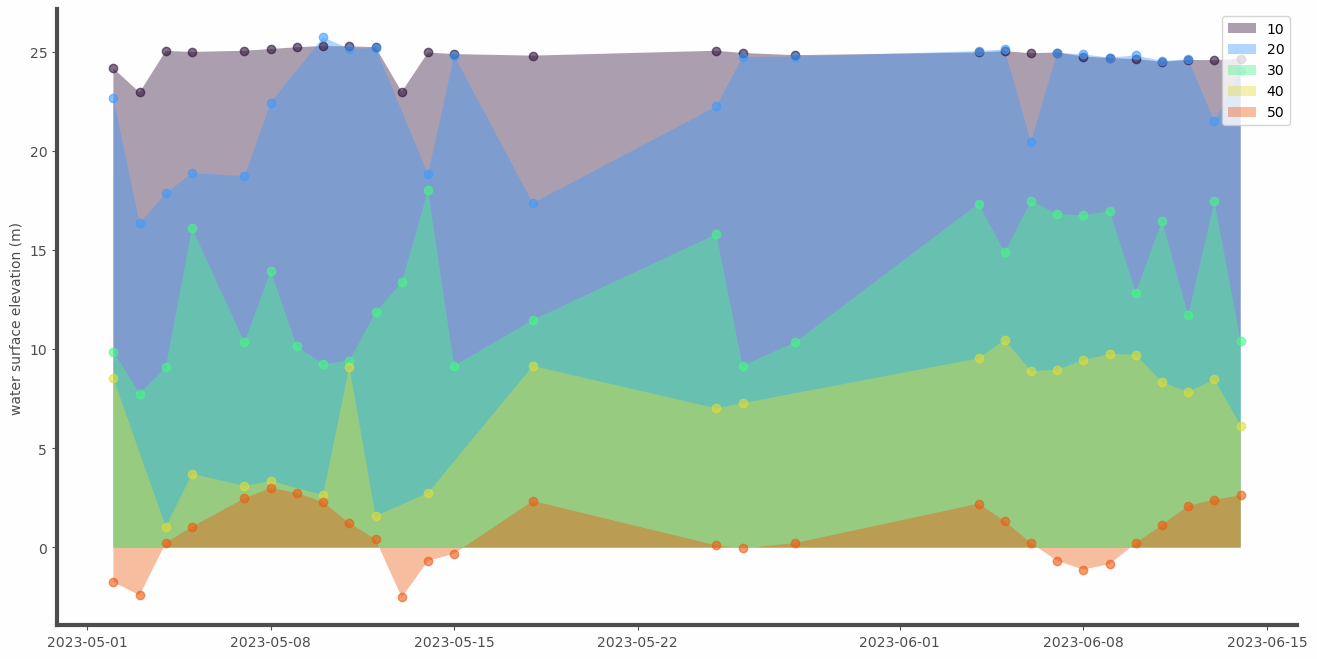

In [ ]:
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    "color", 
    plt.cm.turbo(np.linspace(0,1,len(zones_id)+1))
)

fig, ax = plt.subplots(figsize=(16,8))
fig.patch.set_facecolor('#FEFEFE')
fig.patch.set_alpha(0.8)

for i,id in enumerate(zones_id):
    ax.fill_between(
        df_vs[df_vs['lake_id']==id].date,
        df_vs[df_vs['lake_id']==id][var],
        0., alpha=.4, label=id
    )
    ax.plot(
        df_vs[df_vs['lake_id']==id].date,
        df_vs[df_vs['lake_id']==id][var],
        ls='None', marker='o', alpha=.6, label=None
    )


# Some optional design code
ax.legend(loc=1)
ax.set_ylabel('water surface elevation (m)', color='.3')
ax.patch.set_facecolor('#EFEFEF')
ax.patch.set_alpha(0.)

# Removing axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for spine in ['left', 'bottom']: 
    ax.spines[spine].set_linewidth(3)
    ax.spines[spine].set_color('.3')
ax.tick_params(colors='.3')


# fig.savefig('virtual_stations.png', facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight')

Enjoy!
*L.Zawadzki*